$$r_t=c+\theta_1\epsilon_{t-1}+\epsilon_t$$
- $r_t$ : The values of $r$ in the current period 
- $\theta_1$ : A numeric coefficient for the value associated with the $1^{st}$ lag
- $\epsilon_t$ : Residuals for the period $t$
- $MA(1)\approx AR(∞)$ with certain restrictions
- The $MA$ model relies on the residual instead of the variable by itself
- $\vert \theta_n\vert <1$ : To prevent compounded effects exploding in magnitude
- With $MA$, we rely to $ACF$. The reason is $MA$ models are based on past period returns. Therefore, determining which lagged values have a significant direct effect on the present-day ones is not relevant.

## Importing the relevant packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
from math  import sqrt
import seaborn as sns
from google.colab import drive
import warnings
warnings.filterwarnings("ignore")
sns.set()

In [2]:
drive.mount("/content/drive")

Mounted at /content/drive


## Importing the Data and Pre-processing

In [3]:
raw_csv_data = pd.read_csv("/content/drive/MyDrive/Formations/Time Series/Index2018.csv", index_col="date", parse_dates=True, dayfirst=True)
df_comp = raw_csv_data.copy()
df_comp = df_comp.asfreq("b")
df_comp = df_comp.fillna(method="ffill")

In [4]:
df_comp["market_value"] = df_comp.ftse

In [5]:
df_comp.drop(columns=["spx", "dax", "ftse", "nikkei"], inplace=True)
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp[size:]

## The LLR Test

In [6]:
"""mod_1, mod_2 : models we want to compare
DF : degrees of freedom"""
def LLR_test(mod_1, mod_2, DF=1):
  L1 = mod_1.fit().llf 
  L2 = mod_2.fit().llf
  LR = 2*(L2-L1) 
  p = chi2.sf(LR, DF).round(3)
  return p 

## Creating Returns

In [7]:
df["returns"] = df.market_value.pct_change(1)*100

## ACF for Returns

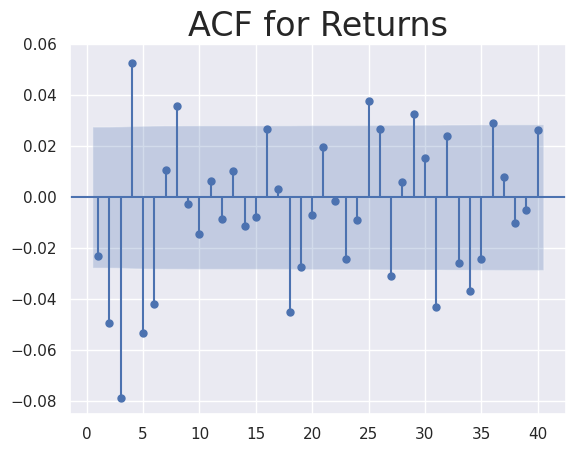

In [8]:
sgt.plot_acf(df.returns[1:], zero = False, lags = 40)
plt.title("ACF for Returns", size=24)
plt.ylim(-0.085, 0.06)
plt.show()

## MA(1) for Returns

In [9]:
model_ret_ma_1 = ARIMA(df.returns[1:], order=(0, 0, 1))
results_ret_ma_1 = model_ret_ma_1.fit()
results_ret_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -7929.595
Date:                Thu, 30 Mar 2023   AIC                          15865.190
Time:                        15:49:20   BIC                          15884.754
Sample:                    01-10-1994   HQIC                         15872.045
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.016      1.146      0.252      -0.013       0.051
ma.L1         -0.0257      0.009     -3.018      0.003      -0.042      -0.009
sigma2         1.3789      0.014     99.990      0.000       1.352       1.406
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              7852.85
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               2.04   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Higher-Lag MA Models for Returns

In [10]:
model_ret_ma_2 = ARIMA(df.returns[1:], order=(0, 0, 2))
results_ret_ma_2 = model_ret_ma_2.fit()
print(results_ret_ma_2.summary())
print("\nLLR test p-value = "+str(LLR_test(model_ret_ma_1, model_ret_ma_2)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(0, 0, 2)   Log Likelihood               -7922.864
Date:                Thu, 30 Mar 2023   AIC                          15853.728
Time:                        15:49:21   BIC                          15879.812
Sample:                    01-10-1994   HQIC                         15862.868
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.016      1.204      0.228      -0.012       0.049
ma.L1         -0.0327      0.009     -3.760      0.000      -0.050      -0.016
ma.L2         -0.0502      0.008     -6.416      0.0

The new coefficient has a p-value of zero, which makes it significant. The same can also be said about the second lag, but not the first. Since the ACF suggests the first period coefficient should not be significant, we can predict that the correct model will have a high p-value for one period ago error term.

In [11]:
model_ret_ma_3 = ARIMA(df.returns[1:], order=(0, 0, 3))
results_ret_ma_3 = model_ret_ma_3.fit()
print(results_ret_ma_3.summary())
print("\nLLR test p-value = "+str(LLR_test(model_ret_ma_2, model_ret_ma_3)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(0, 0, 3)   Log Likelihood               -7904.317
Date:                Thu, 30 Mar 2023   AIC                          15818.634
Time:                        15:49:25   BIC                          15851.240
Sample:                    01-10-1994   HQIC                         15830.060
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.296      0.195      -0.010       0.048
ma.L1         -0.0203      0.009     -2.334      0.020      -0.037      -0.003
ma.L2         -0.0556      0.008     -7.032      0.0

In [12]:
model_ret_ma_4 = ARIMA(df.returns[1:], order=(0, 0, 4))
results_ret_ma_4 = model_ret_ma_4.fit()
print(results_ret_ma_4.summary())
print("\nLLR test p-value = "+str(LLR_test(model_ret_ma_3, model_ret_ma_4)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(0, 0, 4)   Log Likelihood               -7898.773
Date:                Thu, 30 Mar 2023   AIC                          15809.547
Time:                        15:49:30   BIC                          15848.674
Sample:                    01-10-1994   HQIC                         15823.257
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.236      0.217      -0.011       0.049
ma.L1         -0.0203      0.009     -2.239      0.025      -0.038      -0.003
ma.L2         -0.0551      0.008     -6.835      0.0

In [13]:
model_ret_ma_5 = ARIMA(df.returns[1:], order=(0, 0, 5))
results_ret_ma_5 = model_ret_ma_5.fit()
print(results_ret_ma_5.summary())
print("\nLLR test p-value = "+str(LLR_test(model_ret_ma_4, model_ret_ma_5)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(0, 0, 5)   Log Likelihood               -7892.823
Date:                Thu, 30 Mar 2023   AIC                          15799.645
Time:                        15:49:35   BIC                          15845.294
Sample:                    01-10-1994   HQIC                         15815.641
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.282      0.200      -0.010       0.048
ma.L1         -0.0262      0.009     -2.839      0.005      -0.044      -0.008
ma.L2         -0.0497      0.008     -6.147      0.0

In [14]:
model_ret_ma_6 = ARIMA(df.returns[1:], order=(0, 0, 6))
results_ret_ma_6 = model_ret_ma_6.fit()
print(results_ret_ma_6.summary())
print("\nLLR test p-value = "+str(LLR_test(model_ret_ma_5, model_ret_ma_6)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(0, 0, 6)   Log Likelihood               -7889.221
Date:                Thu, 30 Mar 2023   AIC                          15794.442
Time:                        15:49:43   BIC                          15846.612
Sample:                    01-10-1994   HQIC                         15812.723
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.014      1.318      0.188      -0.009       0.047
ma.L1         -0.0237      0.009     -2.562      0.010      -0.042      -0.006
ma.L2         -0.0486      0.008     -5.982      0.0

The results don't change the pattern, this behavior goes on until we go seven periods back to the $MA(7)$.

The $MA(7)$ model produces a non significant coefficient and fails the LR test.

In [15]:
model_ret_ma_7 = ARIMA(df.returns[1:], order=(0, 0, 7))
results_ret_ma_7 = model_ret_ma_7.fit()
print(results_ret_ma_7.summary())
print("\nLLR test p-value = "+str(LLR_test(model_ret_ma_6, model_ret_ma_7)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(0, 0, 7)   Log Likelihood               -7889.046
Date:                Thu, 30 Mar 2023   AIC                          15796.091
Time:                        15:49:50   BIC                          15854.782
Sample:                    01-10-1994   HQIC                         15816.657
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.303      0.193      -0.010       0.047
ma.L1         -0.0247      0.009     -2.645      0.008      -0.043      -0.006
ma.L2         -0.0488      0.008     -6.000      0.0

We add this iteration because if we look at ACF function for returns we examined earlier, we had the coefficient of the $7^{th}$ lag be non significant, but the one for the eighth lag was. Therefore, to be completely through, we shoud bend the general rules of model selection we said earlier, and see how an $MA$ eight model fits the data set.

In [16]:
model_ret_ma_8 = ARIMA(df.returns[1:], order=(0, 0, 8))
results_ret_ma_8 = model_ret_ma_8.fit()
print(results_ret_ma_8.summary())
print("\nLLR test p-value = "+str(LLR_test(model_ret_ma_7, model_ret_ma_8)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(0, 0, 8)   Log Likelihood               -7885.603
Date:                Thu, 30 Mar 2023   AIC                          15791.205
Time:                        15:50:00   BIC                          15856.417
Sample:                    01-10-1994   HQIC                         15814.056
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.253      0.210      -0.011       0.048
ma.L1         -0.0238      0.009     -2.527      0.011      -0.042      -0.005
ma.L2         -0.0495      0.008     -6.053      0.0

At this point, we have :
$$MA(8)>MA(7) \\ MA(6) > MA(7)$$

So w should test :
$$MA(8)\space??\space MA(6)$$

* After estimation, we found $LLR \space test < 0.05$, therefore, the more complicated model performs better than the simpler one even it contains an additional non significant coefficient.

In [17]:
LLR_test(model_ret_ma_6, model_ret_ma_8, DF=2)

0.027

## Residuals for Returns

In [18]:
df["res_ret_ma_8"] = results_ret_ma_8.resid[1:]

In [19]:
print(f"mean : {round(df.res_ret_ma_8.mean(), 3)}")
print(f"std : {round(df.res_ret_ma_8.std(), 3)}")

mean : -0.0
std : 1.164


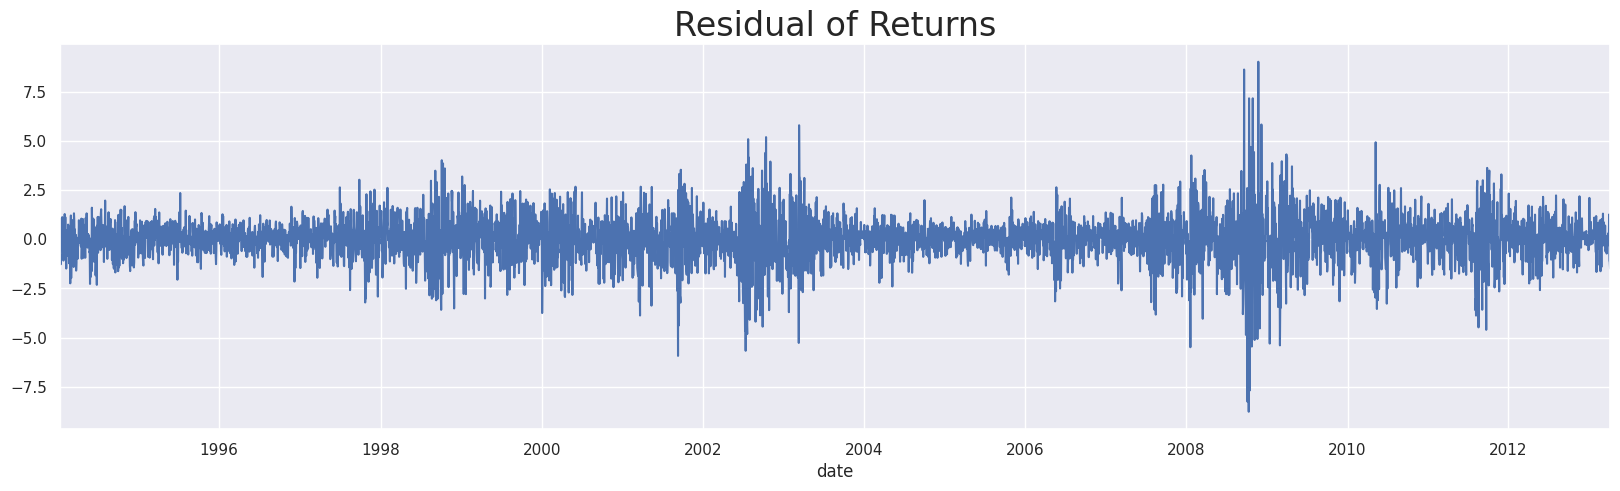

In [20]:
df.res_ret_ma_8[1:].plot(figsize = (20, 5))
plt.title("Residual of Returns", size = 24)
plt.show()

In [21]:
sts.adfuller(df.res_ret_ma_8[2:])

(-70.83537125620856,
 0.0,
 0,
 5018,
 {'1%': -3.4316538358533277,
  '5%': -2.8621161549128313,
  '10%': -2.567076687880585},
 15684.052217389597)

* The first $8$ coefficients are incorporated in the model, so, it's not surprising they're essentially $0$.
* The following $9$ lags are also insignificant and this is a testament to how well our model prforms. The further back in time we go, the less relevant the values and the errors become. 
* Significant coefficients some $18$ lags ago shouldn't play a major role in estimations. This stems from the fact that markets adjust to shocks. So, values far in the past lose relevance.

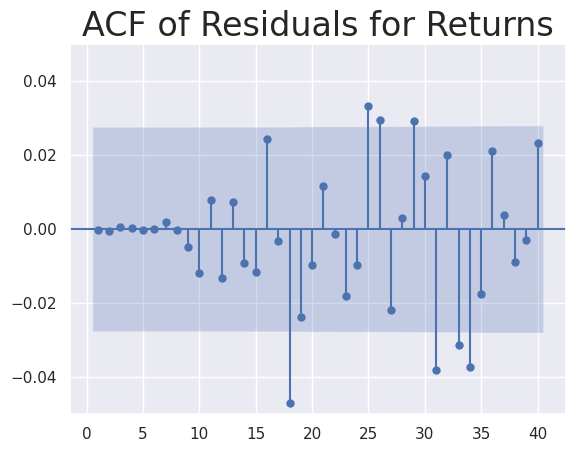

In [22]:
sgt.plot_acf(df.res_ret_ma_8[2:], zero = False, lags = 40)
plt.title("ACF of Residuals for Returns", size = 24)
plt.ylim(-0.05, 0.05)
plt.show()

## Normalized Returns

In [23]:
bench_ret = df.returns.iloc[1]
df["norm_ret"] = df.returns.div(bench_ret).mul(100)

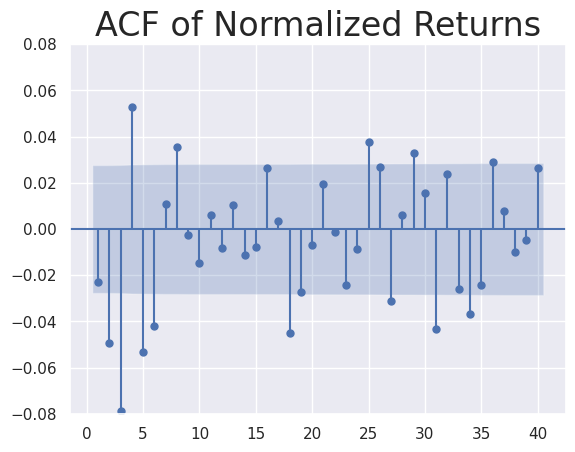

In [24]:
sgt.plot_acf(df.norm_ret[1:], zero = False, lags = 40)
plt.title("ACF of Normalized Returns", size = 24)
plt.ylim(-0.08, 0.08)
plt.show()

In [25]:
model_norm_ret_ma_8 = ARIMA(df.norm_ret[1:], order = (0, 0, 8))
results_norm_ret_ma_8 = model_norm_ret_ma_8.fit()
results_norm_ret_ma_8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               norm_ret   No. Observations:                 5020
Model:                 ARIMA(0, 0, 8)   Log Likelihood              -40307.614
Date:                Thu, 30 Mar 2023   AIC                          80635.228
Time:                        15:50:17   BIC                          80700.440
Sample:                    01-10-1994   HQIC                         80658.079
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.9731      9.658     -1.240      0.215     -30.902       6.956
ma.L1         -0.0238      0.009     -2.518      0.012      -0.042      -0.005
ma.L2         -0.0495      0.008     -6.030      0.000      -0.066      -0.033
ma.L3         -0.0847      0.008    -10.271      0.000      -0.101      -0.069
ma.L4          0.0488      0.009      5.594      0.000       0.032       0.066
ma.L5         -0.0518      0.008     -6.281      0.000      -0.068      -0.036
ma.L6         -0.0402      0.009     -4.394      0.000      -0.058      -0.022
ma.L7          0.0084      0.009      0.935      0.350      -0.009       0.026
ma.L8          0.0365      0.009      3.866      0.000       0.018       0.055
sigma2      5.538e+05   6087.727     90.971      0.000    5.42e+05    5.66e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6440.41
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               2.00   Skew:                             0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
df["res_norm_ret_ma_8"] = results_ret_ma_8.resid[1:]

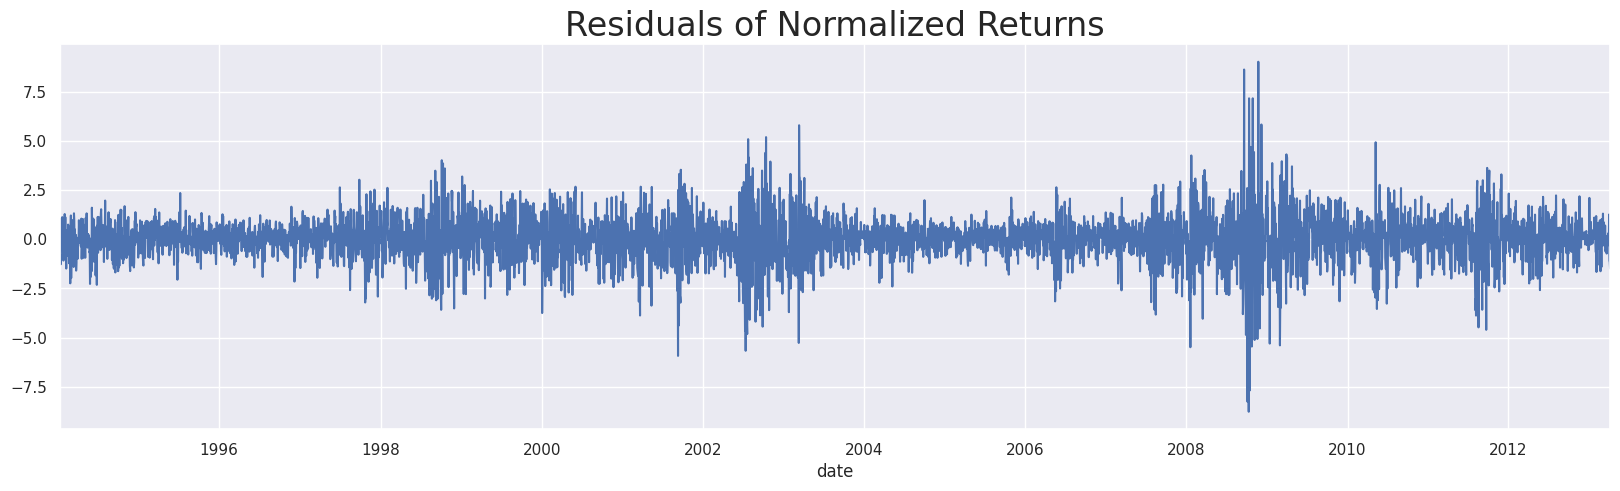

In [27]:
df.res_norm_ret_ma_8[1:].plot(figsize=(20, 5))
plt.title("Residuals of Normalized Returns", size=24)
plt.show()

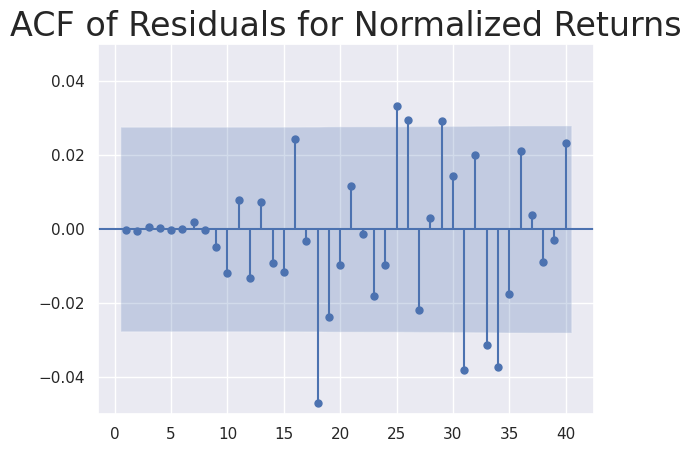

In [28]:
sgt.plot_acf(df.res_norm_ret_ma_8[2:], zero = False, lags = 40)
plt.title("ACF of Residuals for Normalized Returns", size=24)
plt.ylim(-0.05, 0.05)
plt.show()

## MA Models For Prices
* Autoregressive (AR) models are less reliable when estimating non-stationary data.
* The coefficients for all $40$ lags seem to be significant. This suggests that any higher lag model would be preffered to any lower lag $1$. This leads us to beleive that we'd have to use an infinite $MA$ model to fit this data. Since no such thing exists, it seems that no moving average model would be a good estimator of prices but before we completely discredit this reult, let's try to fit several $MA$ models for prices and examine their results.

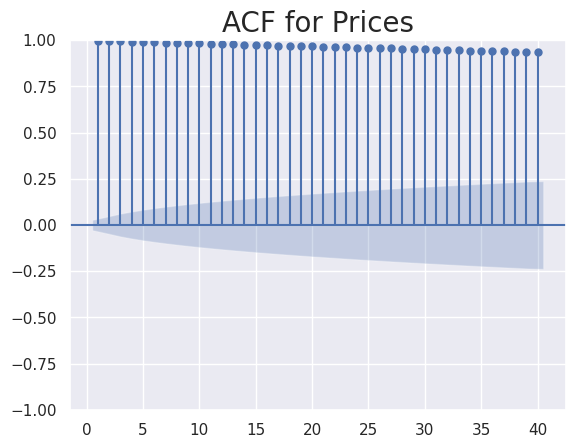

In [29]:
sgt.plot_acf(df.market_value, zero = False, lags = 40)
plt.title("ACF for Prices", size = 20)
plt.show()

We see that the one lag moving average parameter is equal to $0.9573$. This is incredibly close to $1$, which means our model tries to keep almost the entire magnitude of the error from the past period
$$x_{t-1}=c+\theta_1\epsilon_{t-2}+ϵ_{t-1}$$
$$x_{t}=c+\theta_1\epsilon_{t-1}+ϵ_{t}$$
By substitution :
$$x_{t}=c+\theta_1(x_{t-1}-c-\theta_1\epsilon_{t-2})+ϵ_{t}$$
If $\theta_1\approx 1$ :
$$x_{t}=c+x_{t-1}-c-\epsilon_{t-2}+ϵ_{t}$$
$$x_{t}=x_{t-1}-\epsilon_{t-2}+ϵ_{t}$$

This model is autoregressive that takes into account the error from two terms ago.

**Conclusion** :

$MA$ models don't perform well for non-stationary data.

**Solution** :

Combinate $AR$ and $MA$ models.

In [30]:
model_ma_1 = ARIMA(df.market_value, order=(0, 0, 1))
results_ma_1 = model_ma_1.fit()
results_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(0, 0, 1)   Log Likelihood              -38629.000
Date:                Thu, 30 Mar 2023   AIC                          77264.000
Time:                        16:07:27   BIC                          77283.564
Sample:                    01-07-1994   HQIC                         77270.856
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.6316     15.834    321.441      0.000    5058.598    5120.665
ma.L1          0.9573      0.004    231.410      0.000       0.949       0.965
sigma2      2.817e+05   8160.532     34.519      0.000    2.66e+05    2.98e+05
===================================================================================
Ljung-Box (L1) (Q):                4221.11   Jarque-Bera (JB):               291.39
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.44   Skew:                            -0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""